# Aggregating Inputs for Capstone Project

- Begin by cleaning symbols
- Using the `pandas_datareader` to fetch historical prices for:
    - Tickers 
    - ETF's
- Save results to a new csv file 

***

## Gathering data for capstone project. Initial thoughts:

- 10-15yrs of historical asset pricing (create custom ticker list)
- ETF prices for style exposures (iShares Large Cap, etc.)
- Fama & French 
- Use TA-Lib for technical factors

Helpful links:

- https://towardsdatascience.com/python-for-finance-stock-portfolio-analyses-6da4c3e61054
- https://github.com/robertmartin8/MachineLearningStocks#historical-stock-fundamentals

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pandas_datareader as pdr
import fix_yahoo_finance as yf

## Collecting symbols

In [2]:
#Load asset data and reformat
#secs = pd.read_csv('assets.csv')
secs = pd.read_csv('data//assets.csv')

secs['dates'] = pd.DatetimeIndex(secs['Periods'])
cols_to_drop = ['Unnamed: 0', 'Periods', 'Weight', 'Market Capitalization', 
                'country (Fractiles)', 'mval (Fractiles)']
secs.drop(cols_to_drop, axis=1, inplace=True)
#secs['hist_ticker'] = secs['ticker_exchange'].str.split('-').str[0]
#string formatting to query different share classees. Yahoo
#expects ticker-share class
secs['hist_ticker'] = secs['ticker_exchange'].str.split('-')\
.str[0].str.replace('.','-')

#rename columns
secs.columns = ['name', 'ticker_nonpit', 'rets_1m', 'rets_3m', 'country', 'mval', 
                'cusip', 'ticker_region', 'ticker_exchange', 'fsym', 'dates', 'hist_ticker']
#set index, sort, and preview
secs.set_index(['dates', 'hist_ticker'], inplace=True)
secs.sort_index(inplace=True)
secs.head()

name ticker_nonpit  \
dates      hist_ticker                                                  
2003-12-31 A                 Agilent Technologies, Inc.          A-US   
           AA                               Alcoa Corp.         AA-US   
           AAP                 Advance Auto Parts, Inc.        AAP-US   
           ABC            AmerisourceBergen Corporation        ABC-US   
           ABI          Applera Corp-Applied Biosystems    ABI.XX1-US   

                        rets_1m  rets_3m        country      mval      cusip  \
dates      hist_ticker                                                         
2003-12-31 A              26.06     8.17  UNITED STATES  11865.64  00846U101   
           AA            -10.05    -8.32  UNITED STATES  27319.26  013817101   
           AAP            -4.37    -0.07  UNITED STATES   2886.79  00751Y106   
           ABC            -1.96    -2.57  UNITED STATES   6358.37  03073E105   
           ABI            14.15    -4.29  UNITED STATES   4801.26  038020103   

                       ticker_region ticker_exchange      fsym  
dates      hist_ticker                                          
2003-12-31 A                    A-US           A-USA  FWHC5K-R  
           AA                  AA-US          AA-USA  B8374S-R  
           AAP                AAP-US         AAP-USA  HP58X9-R  
           ABC                ABC-US         ABC-USA  BK2FRW-R  
           ABI                ABI-US         ABI-USA  VNRHTY-R

In [3]:
#Num unique tickers
secs.index.get_level_values(1).nunique()

2008

Drop class B & expired tickers - **don't run next cell**

In [4]:
#sec_list = secs.index.get_level_values(1).unique().tolist()
#new_sec_list = [x for x in sec_list if str(x).find('.') == -1]

In [4]:
#assets_df = secs[secs.index.get_level_values(1).isin(new_sec_list)].copy()
asset_ids = secs.index.get_level_values(1).unique().tolist()

Next I'm going to query data from Yahoo Finance for all unique identifiers in my 
sample

***
## *Only execute the two cells below to generate the initial data*

In [31]:
#Track progress 
from tqdm import tqdm

start_date = '2005-12-30'
end_date = '2018-12-31'
dropped_tickers =[]
pricing_data = {}
for ticker in tqdm(asset_ids):
    try:
        pricing_data[ticker] = pdr.data.get_data_yahoo(ticker, 
                                                       start_date, 
                                                       end_date)
    except:
        dropped_tickers.append(ticker)
        
#join data & swap index levels
input_df = pd.concat(pricing_data)

input_df = input_df.swaplevel(0)  #swap levels
input_df.sort_index(level=0, inplace=True)

100%|██████████████████████████████████████████████████████████████████████████████| 2009/2009 [29:06<00:00,  1.26it/s]


In [32]:
#write to csv
input_df.to_csv('data//input_data.csv')

***
# Post Processing

1) Clean up asset pricing and define a final universe of assets over time

2) Gather ETF prices for each sector -- **make note that real estate (XLRE) & communication services (XLC) will be ommitted for our exercise** XLC began on 2018/06

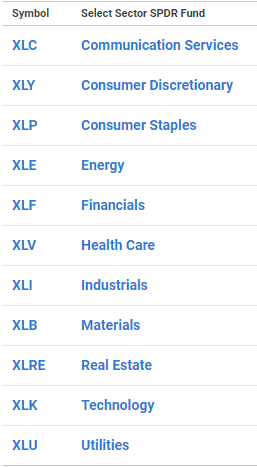

3) Collect Fama & French Style Indices

Source: https://www.sectorspdr.com/sectorspdr/sectors

In [5]:
#Import data
input_df = pd.read_csv('data//input_data.csv')

#Change dates to datetime
input_df['Date'] = pd.to_datetime(input_df['Date'])

#Rename columns
input_df.columns = ['date', 'ticker', 'high', 'low', 'open', 'close', 'volume', 'adj_close']
input_df.set_index(['date', 'ticker'], inplace=True)

#change ticker index to string
input_df.set_index([input_df.index.get_level_values(0), 
                    input_df.index.get_level_values(1).astype(str)], 
                   inplace=True)

Merge earlier DataFrame (secs) with input_df to capture market values for groups

In [6]:
secs.index.names = ['date', 'ticker']

#change ticker index to string
secs.set_index([secs.index.get_level_values(0), 
                secs.index.get_level_values(1).astype(str)], 
               inplace=True)

prices_df = pd.merge(input_df, 
                     secs[['mval']], 
                     how='left', 
                     left_index=True, 
                     right_index=True)

Forward fill market values to convert the monthly series to daily

In [7]:
#Forward fill market values for daily figures
prices_df['mval'] = prices_df.pivot_table(values='mval', 
                                          index='date', 
                                          columns='ticker').fillna(method='ffill').stack()
prices_df['mval_rank'] = prices_df.groupby(level=0)['mval'].rank(ascending=False)

#Limit results to top 600 by market value per date
#Exclude securities with a price above $5
prices_df = prices_df[(prices_df['mval_rank'] <= 600) &\
                      (prices_df['adj_close'] > 5.)]

#Exclude securities with a price above $5
#prices_df = prices_df[prices_df['adj_close'] > 5.]

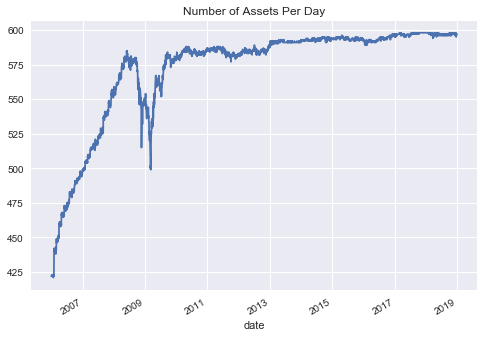

In [8]:
import matplotlib.pyplot as plt

plt.style.use('seaborn')
prices_df.groupby(level=0)['close'].count().plot(title='Number of Assets Per Day');

Create market cap bins to divide securities into large-cap, mid-cap, and small-cap

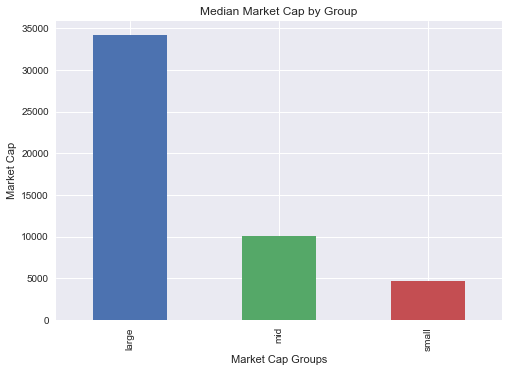

In [9]:
prices_df['mcap_groups'] = prices_df['mval_rank'].groupby(level=0)\
    .apply(lambda x: pd.qcut(x=x, q=3, labels=['large', 'mid', 'small']))

#Display median market cap by group
prices_df.groupby('mcap_groups')['mval'].median().plot(kind='bar', 
                                                     title='Median Market Cap by Group')
plt.ylabel('Market Cap')
plt.xlabel('Market Cap Groups')
plt.show()

### Query prices for sector ETF's

In [16]:
#Define inputs
etf_ids = ['XLY', 'XLP', 'XLE', 'XLF', 'XLV', 'XLI', 'XLB', 'XLK', 'XLU']
start_date = '2005-12-30'
end_date = '2018-12-31'

dropped_etf =[]
etf_pricing = {}
for etf in tqdm(etf_ids):
    try:
        etf_pricing[etf] = pdr.data.get_data_yahoo(etf, start_date, end_date)
    except:
        dropped_etf.append(etf)
        
#join data & swap index levels
etf_prices = pd.concat(etf_pricing)

etf_prices = etf_prices.swaplevel(0)  #swap levels
etf_prices.sort_index(level=0, inplace=True)

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.11s/it]


In [17]:
etf_prices.columns = ['high', 'low', 'open', 'close', 'volume', 'adj_close']
etf_prices.head()

high        low       open      close      volume  \
Date                                                                     
2005-12-30 XLB  30.420000  30.250000  30.420000  30.280001    718200.0   
           XLE  50.700001  49.639999  49.799999  50.310001  12112800.0   
           XLF  25.832657  25.653940  25.727051  25.727051   6315300.0   
           XLI  31.520000  31.389999  31.400000  31.420000    806400.0   
           XLK  20.990000  20.870001  20.990000  20.900000   1029900.0   

                adj_close  
Date                       
2005-12-30 XLB  22.524197  
           XLE  38.575603  
           XLF  14.961567  
           XLI  24.027067  
           XLK  17.223452

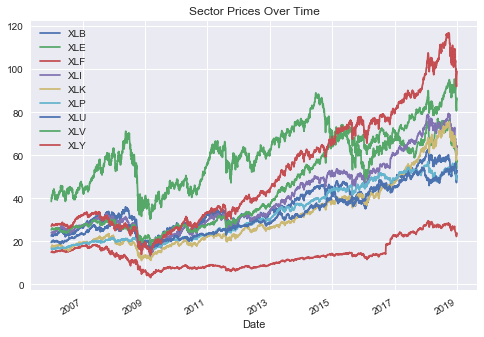

In [19]:
etf_prices['adj_close'].unstack(level=1).plot(title='Sector Prices Over Time');

***
### Write ETF Prices to csv

In [ ]:
#write to csv
etf_prices.to_csv('data//etf_prices.csv')

***

### Import Fama & French Factor Returns

Details: http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/Data_Library/f-f_5developed.html

Good references:

- https://www.quantconnect.com/tutorials/introduction-to-financial-python/fama-french-multi-factor-models
- http://www.quantsportal.com/fama-french-five-factor-asset-pricing-model/


In [10]:
ff_rets = pd.read_csv('data//famafrenchformatted.csv')
ff_rets.columns = ['date', 'mkt-rf', 'smb', 'hml', 'rmw', 'cma', 'rf']
#format dates as datetime
ff_rets['date'] = pd.to_datetime(ff_rets['date'].astype(str))
#set dates to index
ff_rets.set_index('date', inplace=True)
#preview data
ff_rets.head()

,mkt-rf,smb,hml,rmw,cma,rf
date,,,,,,
2005-12-30,-0.42,-0.02,0.29,0.03,0.12,0.01
2006-01-02,-0.03,-0.01,-0.01,0.00,0.00,0.02
2006-01-03,1.59,-0.24,0.16,0.17,-0.26,0.02
2006-01-04,0.52,0.36,-0.14,-0.19,0.09,0.02
2006-01-05,-0.08,0.09,-0.21,-0.50,0.14,0.02


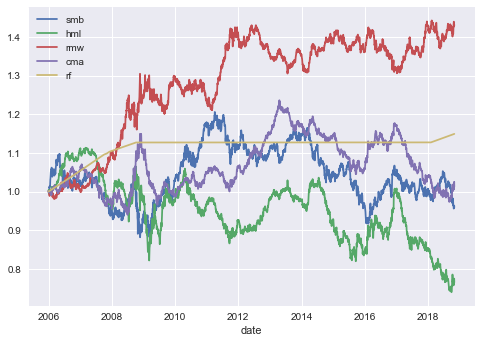

In [11]:
#Display cumulative factor returns
(ff_rets[['smb', 'hml', 'rmw', 'cma', 'rf']]/100+1).cumprod().plot();

Create returns for each of our assets & ETF's before calculating time-series exposures

In [12]:
#Import data -- import when picking back up vs. running pdr
etf_prices = pd.read_csv('data//etf_prices.csv', 
                         index_col=['Date', 'Unnamed: 1'])
etf_prices.index.names = ['date', 'symbol']

In [13]:
#Use adjusted close values for assets
prices_df['daily_ret'] = prices_df.pivot_table(values='adj_close',
                                               index='date', 
                                               columns='ticker').pct_change(periods=1).stack()

#compute daily returns for ETF's
etf_prices['daily_ret'] = etf_prices['adj_close'].unstack().pct_change(periods=1).stack()

***

## Evaluate Prices & Return Streams

Test for outliers with asset returns

In [15]:
#Describe pricing data
prices_df.describe().round(2)

,high,low,open,close,volume,adj_close,mval,mval_rank,daily_ret
count,1872468.00,1872468.00,1872468.00,1872468.00,1.872468e+06,1872468.00,1872468.00,1872468.00,1871480.00
mean,367.47,362.04,364.91,364.87,4.782743e+06,358.99,26945.16,292.49,0.29
std,7602.01,7509.18,7559.42,7556.94,1.284990e+07,7552.84,54714.73,171.04,82.07
min,0.38,0.38,4.12,5.01,0.000000e+00,5.00,890.99,1.00,-1.00
25%,27.53,26.78,27.17,27.17,8.756000e+05,22.61,5736.00,144.00,-0.01
50%,44.52,43.49,44.01,44.01,1.949900e+06,38.04,10436.71,291.00,0.00
75%,72.81,71.31,72.07,72.09,4.412000e+06,64.92,23067.82,438.00,0.01
max,979732.00,979732.00,979732.00,979732.00,1.226791e+09,964377.94,1102393.20,600.00,83063.52


In [16]:
etf_prices.describe()

,high,low,open,close,volume,adj_close,daily_ret
count,29448.000000,29448.000000,29448.000000,29448.000000,2.944800e+04,29448.000000,29439.000000
mean,43.615345,42.996079,43.319161,43.318580,1.810532e+07,38.093685,0.000392
std,19.986124,19.761960,19.878355,19.877679,3.628811e+07,20.208806,0.014220
min,5.239643,4.776604,4.914703,5.020308,1.086000e+05,3.200362,-0.166667
25%,29.150000,28.690001,28.930000,28.937500,5.086025e+06,23.224058,-0.005309
50%,38.759998,38.189999,38.490002,38.490002,8.551350e+06,32.123535,0.000798
75%,55.192499,54.582501,54.910000,54.930000,1.514475e+07,51.244943,0.006615
max,118.129997,117.300003,118.000000,117.790001,1.050592e+09,116.980515,0.309677


C:\Users\jimportico\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


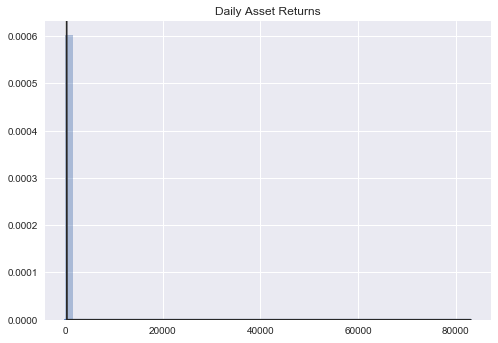

In [14]:
import seaborn as sns
from scipy.stats import norm

sns.distplot(prices_df[['daily_ret']].dropna(), 
             bins=50, fit=norm)
plt.title('Daily Asset Returns')
plt.show()

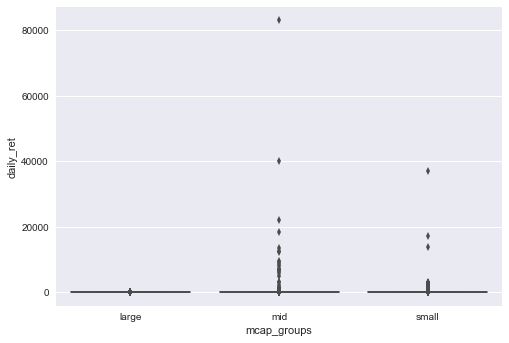

In [18]:
#There are massive outliers present in our smallest cap securities. 
#This isn't too surprising, but we will want to limit the affect they
#Have on our analysis
sns.boxplot(y='daily_ret', x='mcap_groups', data=prices_df, orient='v');

## Method 1: Z-Score

Apply z-scores to the daily returns and exclude companies with values that are > +/- 3 standard deviations from the mean.

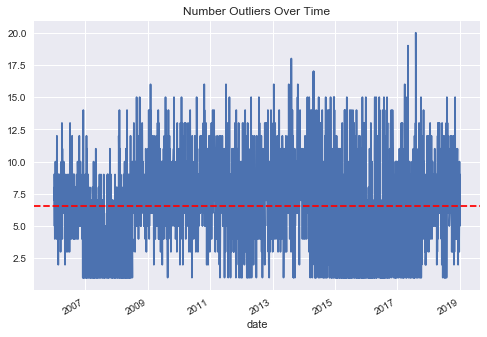

In [247]:
from scipy import stats

#Apply a z-score to standardize each assets' return
prices_df['daily_ret_z'] = prices_df['daily_ret'].groupby(level=0).transform(lambda x: stats.zscore(x))

#Plot the number of securities with daily returns greater than 3 std from the mean
num_outliers = prices_df[prices_df['daily_ret_z'].abs() > 3.]['daily_ret']\
.groupby(level=0).count()
num_outliers.plot(title='Number Outliers Over Time')
plt.axhline(num_outliers.mean(), linestyle='--', color='red')
plt.show()

This method looks sub-optimal for our purposes as it leaves substantial outliers that continue to influence the dataset.

Boxplot for all assets with a return within 3 std of the mean

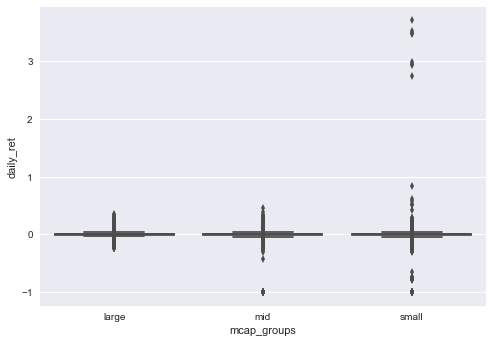

In [248]:
sns.boxplot(y='daily_ret', x='mcap_groups', data=prices_df[prices_df['daily_ret_z'].abs() < 3.], orient='v');

## Method 2: Use Percentile Bounds

Create a series of cutoffs that represent the upper and lower bounds of returns that we'd like to use going forward.

In [15]:
upper_bound = .999 
lower_bound = .001
return_cutoffs = prices_df['daily_ret'].quantile([lower_bound, 
                                                  upper_bound]).values
print("Upper Bound: {:.3f}".format(return_cutoffs[1]))
print("Lower Bound: {:.3f}".format(return_cutoffs[0]))

Upper Bound: 0.175
Lower Bound: -0.153


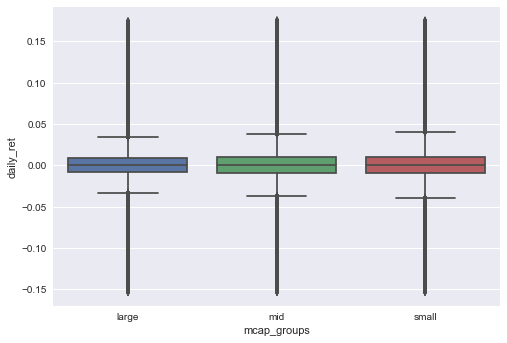

In [16]:
#Define the percentile filter based on the cutoffs
ret_filter = prices_df['daily_ret'].between(return_cutoffs[0],
                                            return_cutoffs[1], 
                                            inclusive=True)

sns.boxplot(y='daily_ret', x='mcap_groups',
            data=prices_df[ret_filter], 
            orient='v');

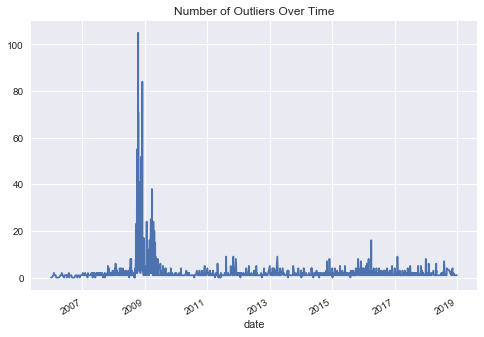

In [17]:
#Display the number of assets beyond the cutoffs
prices_df[ret_filter == False].groupby(level=0)['daily_ret'].count().plot()
plt.title('Number of Outliers Over Time')
plt.show()

Reference for outliers: https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba

Clip returns at the upper and lower bound

In [18]:
prices_df['daily_ret'].clip_upper(return_cutoffs[1], axis=0, inplace=True)
prices_df['daily_ret'].clip_lower(return_cutoffs[0], axis=0, inplace=True)

C:\Users\jimportico\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


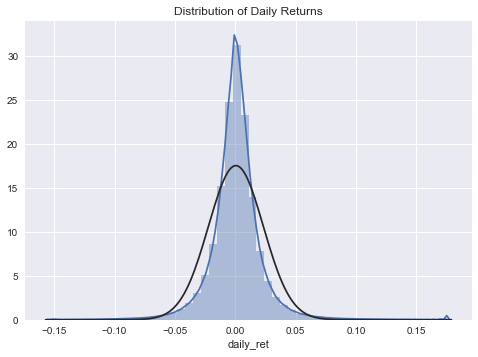

In [19]:
sns.distplot(prices_df['daily_ret'].dropna(), bins=50, fit=norm)
plt.title('Distribution of Daily Returns')
plt.show()

***
## Create Exposures to Sectors & Fama French Factors

### Sector exposures

• Time-Series Exposures:

    o Sectors:
        ▪ Beta to Communication Services (XLC)
        ▪ Beta to Consumer Discretionary (XLY)
        ▪ Beta to Consumer Staples (XLP)
        ▪ Beta to Energy (XLE)
        ▪ Beta to Financials (XLF)
        ▪ Beta to Health Care (XLV)
        ▪ Beta to Industrials (XLI)
        ▪ Beta to Materials (XLB)
        ▪ Beta to Technology (XLK)
        ▪ Beta to Utilities (XLU)
    

In [20]:
etf_ids = ['XLY', 'XLP', 'XLE', 'XLF', 'XLV', 'XLI', 'XLB', 'XLK', 'XLU']

sector_betas_dict = {}
for etf in etf_ids:
    cov = prices_df.pivot_table(values='daily_ret',
                                index='date', 
                                columns='ticker').rolling(252).cov(etf_prices['daily_ret'].unstack()[etf])
    
    var = etf_prices['daily_ret'].unstack()[etf].rolling(252).var()
    
    sector_betas_dict[etf] = cov.apply(lambda x: x / var)

sector_betas = pd.DataFrame({k:v.stack() for k, v in sector_betas_dict.items()})

### Fama & French Exposures

Align the calendars between the two datasets. Right now the Fama & French data is based on North American securities, so it's using a combination of US & Canadian trading days vs. US only.

In [21]:
us_dates = prices_df.index.get_level_values(0).unique()
ff_rets = ff_rets[ff_rets.index.isin(us_dates)]

In [22]:
ff_betas_dict = {}
for factor in ff_rets.columns:
    cov = prices_df.pivot_table(values='daily_ret',
                                index='date', 
                                columns='ticker').rolling(252).cov(ff_rets[factor]/100)
    
    var = (ff_rets[factor]/100).rolling(252).var()
    
    ff_betas_dict[factor] = cov.apply(lambda x: x / var)

ff_betas = pd.DataFrame({k:v.stack() for k, v in ff_betas_dict.items()})
ff_betas.drop('rf', axis=1, inplace=True)

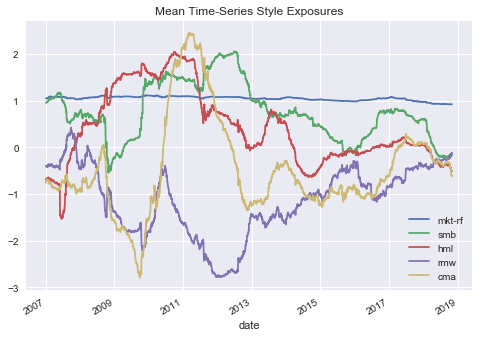

In [23]:
ff_betas.groupby(level=0).mean().plot(title='Mean Time-Series Style Exposures')
plt.show()

***
## Creating Features

Beginning the signal generation process by creating features with Pandas. Next, we'll move onto the `talib` library.
***
- % Above/Below Moving Average Price - 30 day, 50 day, and 200 day
- % Above/Below 52 week high and low price
- Binary flags for if current price > 30d_mavg; 30d_mavg > 50d_mavg; 50d_mavg > 200d_mavg

In [624]:
#Unstack data to create a time-series view
adj_close = prices_df.pivot_table(values=['adj_close'],
                                  index='date', 
                                  columns='ticker')

fast_period = 30
med_period = 50
slow_period = 200
factor_data = {}
for period in [fast_period, med_period, slow_period]:
    """
    All moving averages require at least 80% of the underlying
    data points to be available.
    """
    factor_data[str(period)+'d_mavg'] = adj_close['adj_close'].rolling(period, 
                                                                  min_periods=(int(period*.8))).mean().stack()
    
factor_data = pd.DataFrame(factor_data)

In [625]:
factor_data = pd.merge(factor_data, 
                       prices_df[['adj_close', 'mcap_groups']],
                       how='outer', 
                       right_index=True, 
                       left_index=True)

Binary Moving Average Indicators

In [626]:
#Price > 30D Moving Average Price
factor_data['p_gt_30d'] = np.where(factor_data['adj_close'] > factor_data['30d_mavg'], 1, 0)

#Price > 50D Moving Average Price
factor_data['p_gt_50d'] = np.where(factor_data['adj_close'] > factor_data['50d_mavg'], 1, 0)

#Price > 200D Moving Average Price
factor_data['p_gt_200d'] = np.where(factor_data['adj_close'] > factor_data['200d_mavg'], 1, 0)

#30D Moving Average Price > 50D Moving Average Price
factor_data['30d_gt_50d'] = np.where(factor_data['30d_mavg'] > factor_data['50d_mavg'], 1, 0)

#50D Moving Average Price > 200D Moving Average Price
factor_data['50d_gt_200d'] = np.where(factor_data['50d_mavg'] > factor_data['200d_mavg'], 1, 0)

Percent Change from Moving Averages

In [640]:
#Percent above 30d moving average
factor_data['perc_above30d'] = (factor_data['adj_close'] / factor_data['30d_mavg'] - 1) * 100

#Percent above 50d moving average
factor_data['perc_above50d'] = (factor_data['adj_close'] / factor_data['50d_mavg'] - 1) * 100

#Percent above 200d moving average
factor_data['perc_above200d'] = (factor_data['adj_close'] / factor_data['200d_mavg'] - 1) * 100

Calculate Percent Above and Below the 52 Week High & Low

In [642]:
#1yr high & low prices
factor_data['oneyr_high'] = adj_close['adj_close'].rolling(252, 
                                                           min_periods=int(252*.8)).max().stack()

factor_data['oneyr_low'] = adj_close['adj_close'].rolling(252, 
                                                          min_periods=int(252*.8)).min().stack()

In [644]:
#Percent above 52 week high
factor_data['perc_above52wh'] = (factor_data['adj_close'] / factor_data['oneyr_high'] - 1) * 100

#Percent above 52 week low
factor_data['perc_above52wl'] = (factor_data['adj_close'] / factor_data['oneyr_low'] - 1) * 100

Define long-term & short-term momentum:

- Long-term Momentum: 12M - 1M Price Change
- Medium-term Momentum: 6M - 1M Price Change
- Short-term Momentum: Price change over most recent month

In [645]:
#Long-term momentum - 12 - 1M price momentum
factor_data['lt_momentum'] = adj_close.apply(lambda x: x.shift(21) / x.shift(252) - 1).stack()

#Medium-term momentum - 6 - 1M price momentum
factor_data['mt_momentum'] = adj_close.apply(lambda x: x.shift(21) / x.shift(126) - 1).stack()

#Short-term momentum
factor_data['st_momentum'] = adj_close.apply(lambda x: x / x.shift(21) - 1).stack()

Define stock price volatility over 1, 3, 6, and 12 months

In [646]:
#Query daily returns
daily_rets = prices_df.pivot_table(values=['daily_ret'],
                                   index='date', 
                                   columns='ticker')

#Define horizons for volatility factors
vol_horizons = [x*21 for x in [1, 3, 6, 12]]

for period in vol_horizons:
    """
    All volatilities require at least 80% of the underlying
    data points to be available.
    """
    factor_data[str(period)+'d_vol'] = (daily_rets['daily_ret'].rolling(period, 
                                                                  min_periods=(int(period*.8)))\
                                      .std() * np.sqrt(252)).stack()

Construct technical factors using `talib`
    
    • Relative Strength Index (RSI)
    • Moving Average Signal Convergence Divergence (MACD)
    • On Balance Volume (OBV)
    • Money Flow Index
    • Directional Movement Index (DX)
    • Stochastic Oscillator
    • Average True Range (ATR)      

In [647]:
import talib as ta

pricing_pivot = prices_df.pivot_table(values=['high', 'low', 'open', 'close', 'volume', 'adj_close'],
                                      index='date', 
                                      columns='ticker')

In [648]:
#RSI
factor_data['RSI'] = adj_close.apply(lambda x: ta.RSI(x, timeperiod=14)).stack()

#MACD
for i, signal in enumerate(['macd', 'macdsignal', 'macdhist']):
    factor_data[signal] = adj_close['adj_close']\
    .apply(lambda x: ta.MACD(x, 
                             fastperiod=12, 
                             slowperiod=26, 
                             signalperiod=9)[i]).stack()

#BOP, MFI, DX, STOCH_OSC, ATR
bop = {}
mfi = {}
dx = {}
stoch_osc = {}
ATR = {}
for i, sec in enumerate(pricing_pivot['adj_close'].columns.tolist()):
    open_p = pricing_pivot['open'].iloc[:, i]
    high = pricing_pivot['high'].iloc[:, i]
    low = pricing_pivot['low'].iloc[:, i]
    close = pricing_pivot['close'].iloc[:, i]
    volume = pricing_pivot['volume'].iloc[:, i]
    
    try:        
        bop[sec] = ta.BOP(open_p, high, low, close)
        mfi[sec] = ta.MFI(high, low, close, volume, timeperiod=14)
        dx[sec] = ta.DX(high, low, close, timeperiod=14)
        stoch_osc[sec] = ta.ULTOSC(high, low, close, timeperiod1=7, timeperiod2=14, timeperiod3=28)
        ATR[sec] = ta.ATR(high, low, close, timeperiod=14)      
        
    except:
        pass

Combine dictionaries for technical factors

In [649]:
tech_factor_dictionaries = [bop, mfi, dx, stoch_osc, ATR]
tech_factor_names = ['bop', 'mfi', 'dx', 'stoch_osc', 'atr']
tech = []
for factor, col in zip(tech_factor_dictionaries, tech_factor_names):
    df = pd.DataFrame(pd.concat(factor), columns=[col])
    df = df.swaplevel()
    df.sort_index(level=0, inplace=True)
    tech.append(df)
    
tech_factors = pd.concat(tech, axis=1)
tech_factors.index.names = ['date', 'ticker']

Join all factors together

In [652]:
all_factors = pd.merge(factor_data, 
                       tech_factors, 
                       how='outer', 
                       right_index=True,
                       left_index=True)

betas = pd.merge(ff_betas, 
                 sector_betas, 
                 how='outer',
                 right_index=True, 
                 left_index=True)

all_factors = pd.merge(all_factors, 
                       betas, 
                       how='outer',
                       right_index=True, 
                       left_index=True)

Write final factor data to csv

In [673]:
all_factors.to_csv('data//all_factors.csv')

# PICK UP HERE WITH EDA & ML

## Feature Engineering

Now we will take our inputs and begin creating our features:


    • Relative Strength Index (RSI)
    • Moving Average Signal Convergence Divergence (MACD)
    • Long-Term Momentum: Price change over several horizons
    • Short-Term Reversal: Price change over several near-term horizons
    • Percent above and below the 52-week high and low price
    • Percent above and below the 30 and 200 days moving average price
    • Volatility: Standard deviation of returns over several horizons
    • Money Flow Index
    • Directional Movement Index (DX)
    • Stochastic Oscillator
    • Average True Range (ATR)
    • Time-Series Exposures:
        o Sectors:
            ▪ Beta to Communication Services (XLC)
            ▪ Beta to Consumer Discretionary (XLY)
            ▪ Beta to Consumer Staples (XLP)
            ▪ Beta to Energy (XLE)
            ▪ Beta to Financials (XLF)
            ▪ Beta to Health Care (XLV)
            ▪ Beta to Industrials (XLI)
            ▪ Beta to Materials (XLB)
            ▪ Beta to Technology (XLK)
            ▪ Beta to Utilities (XLU)
        o Styles:
            ▪ Beta to Fama & French SMB (Small Minus Big) portfolios
            ▪ Beta to Fama & French HML (High Minus Low) portfolios
            
*** 

Create daily return streams for assets and ETF's

In [103]:
#Import standard plotly modules
import plotly.graph_objs as go
import plotly.plotly as py

#Import Cufflinks wrapper for plotly
import cufflinks

# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

#REMOVE THIS BEFORE SUBMITTING
import plotly
plotly.tools.set_credentials_file(username='joeImp', 
                                  api_key='W9WYzHG9QeYTZiM53w6E')